# Slow Decaying Positional Encoding

$$ PE_{pos, 2i} = \frac{2i}{d} \sin{ \left( \sqrt{pos} \right)}  $$
$$ PE_{pos, 2i+1} = \frac{2i+1}{d} \cos{\left( \sqrt{pos} \right)}  $$

In [22]:
from helper import has_duplicate_rows, draw
from torch import nn
import torch


class SlowDecayingPositionalEncoding(nn.Module):
    """
    Slow Decaying Positional Encoding
    """

    def __init__(self, max_len: int, d_model: int, dropout: float = 0):
        super(SlowDecayingPositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.unsqueeze(torch.arange(start=1, end=max_len + 1), dim=1)  # Shape is torch.Size([max_len, 1])

        term_odd = torch.exp(
            torch.log(torch.arange(start=1, end=d_model + 1, step=2)) -
            torch.log(torch.Tensor([d_model]))
        )  # Shape is torch.Size([max_len, d_model / 2])

        term_even = torch.exp(
            torch.log(torch.arange(start=2, end=d_model + 2, step=2)) -
            torch.log(torch.Tensor([d_model]))
        )  # Shape is torch.Size([max_len, d_model / 2])

        pe[:, 0::2] = term_odd * torch.sin(torch.sqrt(position))  # pe_pos_2i
        pe[:, 1::2] = term_odd * torch.cos(torch.sqrt(position))  # pe_pos_2i+1

        pe = torch.unsqueeze(pe, dim=0)  # Shape is torch.Size([1, max_len, d_model])

        if has_duplicate_rows(pe):
            raise Warning(
                'The positional encoding matrix contains invalid encoding rows, which may result in the loss of positional information. Please reduce the value of the "max_len" parameter.')
        else:
            print('You are using an experimental feature: SlowDecayingPositionalEncoding')
        self.register_buffer(name='pe', tensor=pe)  # Buffer

    def forward(self, x: torch.Tensor):
        # dim(x) => max_char_num * d_model
        x = x + self.pe[:, :x.size(1)].requires_grad_(False)  # Prevent from calculating gradients.
        return self.dropout(x)  # Stochastically dropout elements


# Parameters
max_len = 20000
d_model = 512

# Initialize module and output the data
pe = SlowDecayingPositionalEncoding(max_len, d_model).pe
pe

tensor([[[ 1.6435e-03,  1.0553e-03,  4.9305e-03,  ...,  5.3714e-01,
           8.3983e-01,  5.3925e-01],
         [ 1.9292e-03,  3.0458e-04,  5.7877e-03,  ...,  1.5503e-01,
           9.8584e-01,  1.5564e-01],
         [ 1.9278e-03, -3.1359e-04,  5.7834e-03,  ..., -1.5962e-01,
           9.8510e-01, -1.6024e-01],
         ...,
         [-8.3221e-05, -1.9514e-03, -2.4966e-04,  ..., -9.9324e-01,
          -4.2526e-02, -9.9714e-01],
         [-9.0098e-05, -1.9510e-03, -2.7030e-04,  ..., -9.9308e-01,
          -4.6040e-02, -9.9698e-01],
         [-9.7005e-05, -1.9507e-03, -2.9101e-04,  ..., -9.9291e-01,
          -4.9569e-02, -9.9682e-01]]])
torch.Size([1, 20000, 512])
You are using an experimental feature: SlowDecayingPositionalEncoding


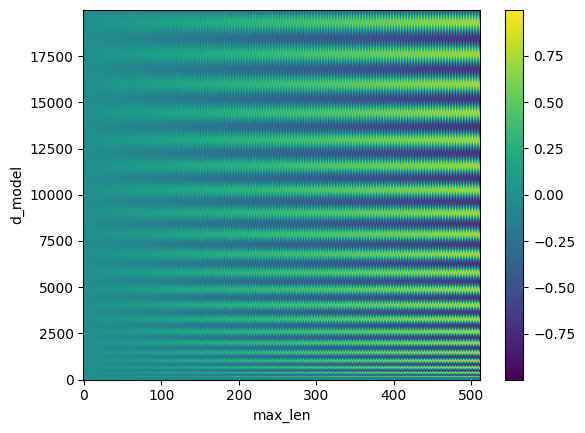

In [23]:
draw(pe)